<a href="https://colab.research.google.com/github/mlaugharn/math189bigdata/blob/master/dfdc_final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 1. for frame in 30 frames from each video
# 2. extract all faces
# 3. pad faces w/ 30% margin to be ~300x300 px
# 4. train efficientnet-b3 model on cropped faces + augmentations
# 5. test



In [1]:
!pip install facenet-pytorch opencv-python numpy tqdm

In [2]:
!pip install "torch==1.4" "torchvision==0.5.0"

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
# Below is the code used to preprocess from the original kaggle dataset 
# | | | | | | | |
# | | | | | | | |
# v v v v v v v v


from facenet_pytorch import MTCNN, InceptionResnetV1
import glob
import cv2
from PIL import Image
from tqdm.autonotebook import tqdm
import json

data_dir = '/gdrive/My Drive/dfdc/'
    
labels = {}
def get_labels():
    global labels
    # split = train or test
    labels = json.load(open(data_dir + 'train_sample_videos/metadata.json', 'r'))

def get_label(video_file_name):
    return labels[video_file_name]["label"]

def video_frames(videopath, select_num_frames=10): # extract frames
    reader = cv2.VideoCapture(videopath)
    numframes = int(reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_spacing = int(numframes/select_num_frames)
    for frameno in range(numframes):
        success = reader.grab()
        if select_num_frames == None or frameno % frame_spacing == 0 or frameno == numframes-1:
            success, image = reader.retrieve()
            if not success:
                print(f"failure: {videopath} fr# {frameno} / {numframes}")
            frame = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if frameno == numframes-1: reader.release() # always also send last frame so that we can subsequently free up the reader
            yield frameno, frame

def train_videos():
    n = 0
    directory = data_dir + 'train_sample_videos'
    for path in glob.iglob(directory + '/*.mp4'):
        video_file_name = path[len(directory)+1:]
        yield n, path, video_file_name
        n += 1

def test_videos():
    n = 0
    directory = data_dir + 'test_videos'
    for path in glob.iglob(directory + '/*.mp4'):
        video_file_name = path[len(directory)+1:]
        yield n, path, video_file_name
        n += 1


import os, os.path
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from tqdm.autonotebook import tqdm
import glob
import torch
import json
from torchvision.transforms import ToTensor, ToPILImage, Normalize
import torchvision.transforms as transforms
import torch.nn.functional as F
import scipy
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn import preprocessing
import subprocess
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

mtcnn = MTCNN(select_largest = True, margin=20, post_process=False, device=device)

def turn_videos_into_fastai_folders2(): # call this to turn data into face frame folders
    location = '/gdrive/My Drive/dfdc/frame folders3/'
    if not os.path.isdir(location): os.mkdir(location)
    if not os.path.isdir(location + 'train'): os.mkdir(location + 'train')
    if not os.path.isdir(location + 'train/REAL'): os.mkdir(location + 'train/REAL')
    if not os.path.isdir(location + 'train/FAKE'): os.mkdir(location + 'train/FAKE')
    if not os.path.isdir(location + 'test'): os.mkdir(location + 'test')
  
    for videonumber, videopath, videofilename in tqdm(train_videos()):
        vidlabel = get_label(videofilename)
        print(f"working on video {videonumber}: {videofilename}...")
        for framenum, frame in tqdm(video_frames(videopath, select_num_frames=15)):
            boxes, confidences = mtcnn.detect(frame, landmarks=False)
            print(boxes)
            if (boxes is not None) and (len(boxes) > 0):
                for facenum, (box, confidence) in enumerate(zip(boxes, confidences)):
                    if confidence > .9:
                        dx = box[2] - box[0]
                        dy = box[3] - box[1]
                        margmul = .3
                        x1, x2 = box[0] - margmul*dx, box[2] + margmul * dx
                        y1, y2 = box[1] - margmul*dy, box[3] + margmul * dy
                        x1 = max(0, min(x1, frame.width))
                        x2 = max(0, min(x2, frame.width))
                        y1 = max(0, min(y1, frame.height))
                        y2 = max(0, min(y2, frame.height))
                        facecrop = frame.copy().crop([x1, y1, x2, y2]).resize((300, 300))
                        facecrop.save(f"{location}/train/{vidlabel}/{videofilename}_{framenum}_{facenum}.png")
    
    for videonumber, videopath, videofilename in tqdm(test_videos()):
        print(f"working on video {videonumber}: {videofilename}...")
        for framenum, frame in tqdm(video_frames(videopath, select_num_frames=15)):
            boxes, confidences = mtcnn.detect(frame, landmarks=False)
            print(boxes)
            if (boxes is not None) and (len(boxes) > 0):
                for facenum, (box, confidence) in enumerate(zip(boxes, confidences)):
                    if confidence > .9:
                        dx = box[2] - box[0]
                        dy = box[3] - box[1]
                        margmul = .3
                        x1, x2 = box[0] - margmul*dx, box[2] + margmul * dx
                        y1, y2 = box[1] - margmul*dy, box[3] + margmul * dy
                        x1 = max(0, min(x1, frame.width))
                        x2 = max(0, min(x2, frame.width))
                        y1 = max(0, min(y1, frame.height))
                        y2 = max(0, min(y2, frame.height))
                        facecrop = frame.copy().crop([x1, y1, x2, y2]).resize((300, 300))
                        facecrop.save(f"{location}/test/{videofilename}_{framenum}_{facenum}.png")

get_labels()


In [0]:
validation_prefixes = []
import random
def gen_validation(split_pct=0.2): # create list of names of the frames that end up in validation set such that there is no leakage of frames of a video in validation set into the training set
    global validation_prefixes
    for _, _, video_filename in train_videos():
        if random.random() < split_pct: 
            validation_prefixes.append(video_filename)

gen_validation()
def is_validation(filename):
    bname = os.path.basename(filename)
    for prefix in validation_prefixes: # prevent frames with same prefix from being in both train set and validation set
        if bname.startswith(prefix): return 'train' in str(filename)
    return False

In [0]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d ./shape_predictor_68_face_landmarks.dat.bz2

In [0]:
from matplotlib import pyplot as plt
import numpy as np
import torch.nn as nn
import torch
from torchvision import transforms
from fastai.vision import  *
import dlib

import albumentations as A

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")

# wrapper code to allow albumentations transforms to work with fastai transforms

def tensor2np(x):
    np_image = x.cpu().permute(1, 2, 0).numpy()
    np_image = (np_image * 255).astype(np.uint8)
    
    return np_image

def alb_tfm2fastai(alb_tfm):
    def _alb_transformer(x):
        # tensor to numpy
        np_image = tensor2np(x)

        # apply albumentations
        transformed = alb_tfm(image=np_image)['image']

        # back to tensor
        tensor_image = pil2tensor(transformed, np.float32)
        tensor_image.div_(255)

        return tensor_image

    transformer = TfmPixel(_alb_transformer)
    
    return transformer()

In [8]:
!pip install imutils

In [0]:
from imutils import face_utils
import scipy.misc

# facial feature mask as described in project report
def mask_face(img):
    if random.random() > 0.333: return img
    #dlib landmarks indices
    mouth= (48, 68)
    right_eyebrow =(17, 22)
    left_eyebrow = (22, 27)
    right_eye = (36, 42)
    left_eye = (42, 48)
    nose = (27, 35)
    jaw = (0, 17)
    pieces = [mouth, right_eyebrow, left_eyebrow, right_eye, left_eye, nose, jaw]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    result = img
    for (i, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        chance = random.random()
        if chance <= 0.333: # whole face
            pts = shape[0:68]
            mask = cv2.convexHull(pts)
            contours = [mask]
        elif 0.333 < chance <= 0.666: # 3 random facial features
            masked_piece1 = random.choice(pieces)
            pieces.remove(masked_piece1)
            masked_piece2 = random.choice(pieces)
            pieces.remove(masked_piece2)
            masked_piece3 = random.choice(pieces)
            pieces.remove(masked_piece3)

            j1, k1 = masked_piece1
            pts1 = shape[j1:k1]
            mask1 = cv2.convexHull(pts1)
            
            j2, k2 = masked_piece2
            pts2 = shape[j2:k2]
            mask2 = cv2.convexHull(pts2)
            
            j3, k3 = masked_piece3
            pts3 = shape[j3:k3]
            mask3 = cv2.convexHull(pts3)

            contours = [mask1, mask2, mask3]
        else:
            # random interval of facial feature points
            i1, i2 = random.randint(0, 34), random.randint(35, 68)
            
            mask = cv2.convexHull(shape[i1:i2])
            contours = [mask]
        stencil = np.zeros(img.shape).astype(img.dtype) # create mask of white area on black background from collected masks
        cv2.fillPoly(stencil, contours, [255,255,255])
        dilation = random.randint(10, 60) # expand the mask randomly
        kernel = np.ones((dilation, dilation)).astype(img.dtype)
        dilated_stencil = cv2.dilate(stencil, kernel, iterations=random.randint(1,3))
        result = cv2.bitwise_and(img, dilated_stencil) # mask the image
        break
    return result
def tfmMaskfastai():
    def _mask2fastai(img):
        np_img = tensor2np(img)
        result = mask_face(np_img)
        tensor_img = pil2tensor(result, np.float32)
        tensor_img.div_(255)
        return tensor_img
    transformer = TfmPixel(_mask2fastai)
    return transformer()

In [10]:

Atfms = [alb_tfm2fastai(tfm) for tfm in [A.Blur(blur_limit=3, p=0.5), A.JpegCompression(quality_lower=65, p = 0.35)]] + [tfmMaskfastai()]
transforms = get_transforms(max_warp=None, xtra_tfms=Atfms)
import pprint
pprint.pprint(transforms)

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (alb_transformer), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=Tru

In [11]:
!nvidia-smi

Tue May 12 03:16:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    41W / 250W |    739MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

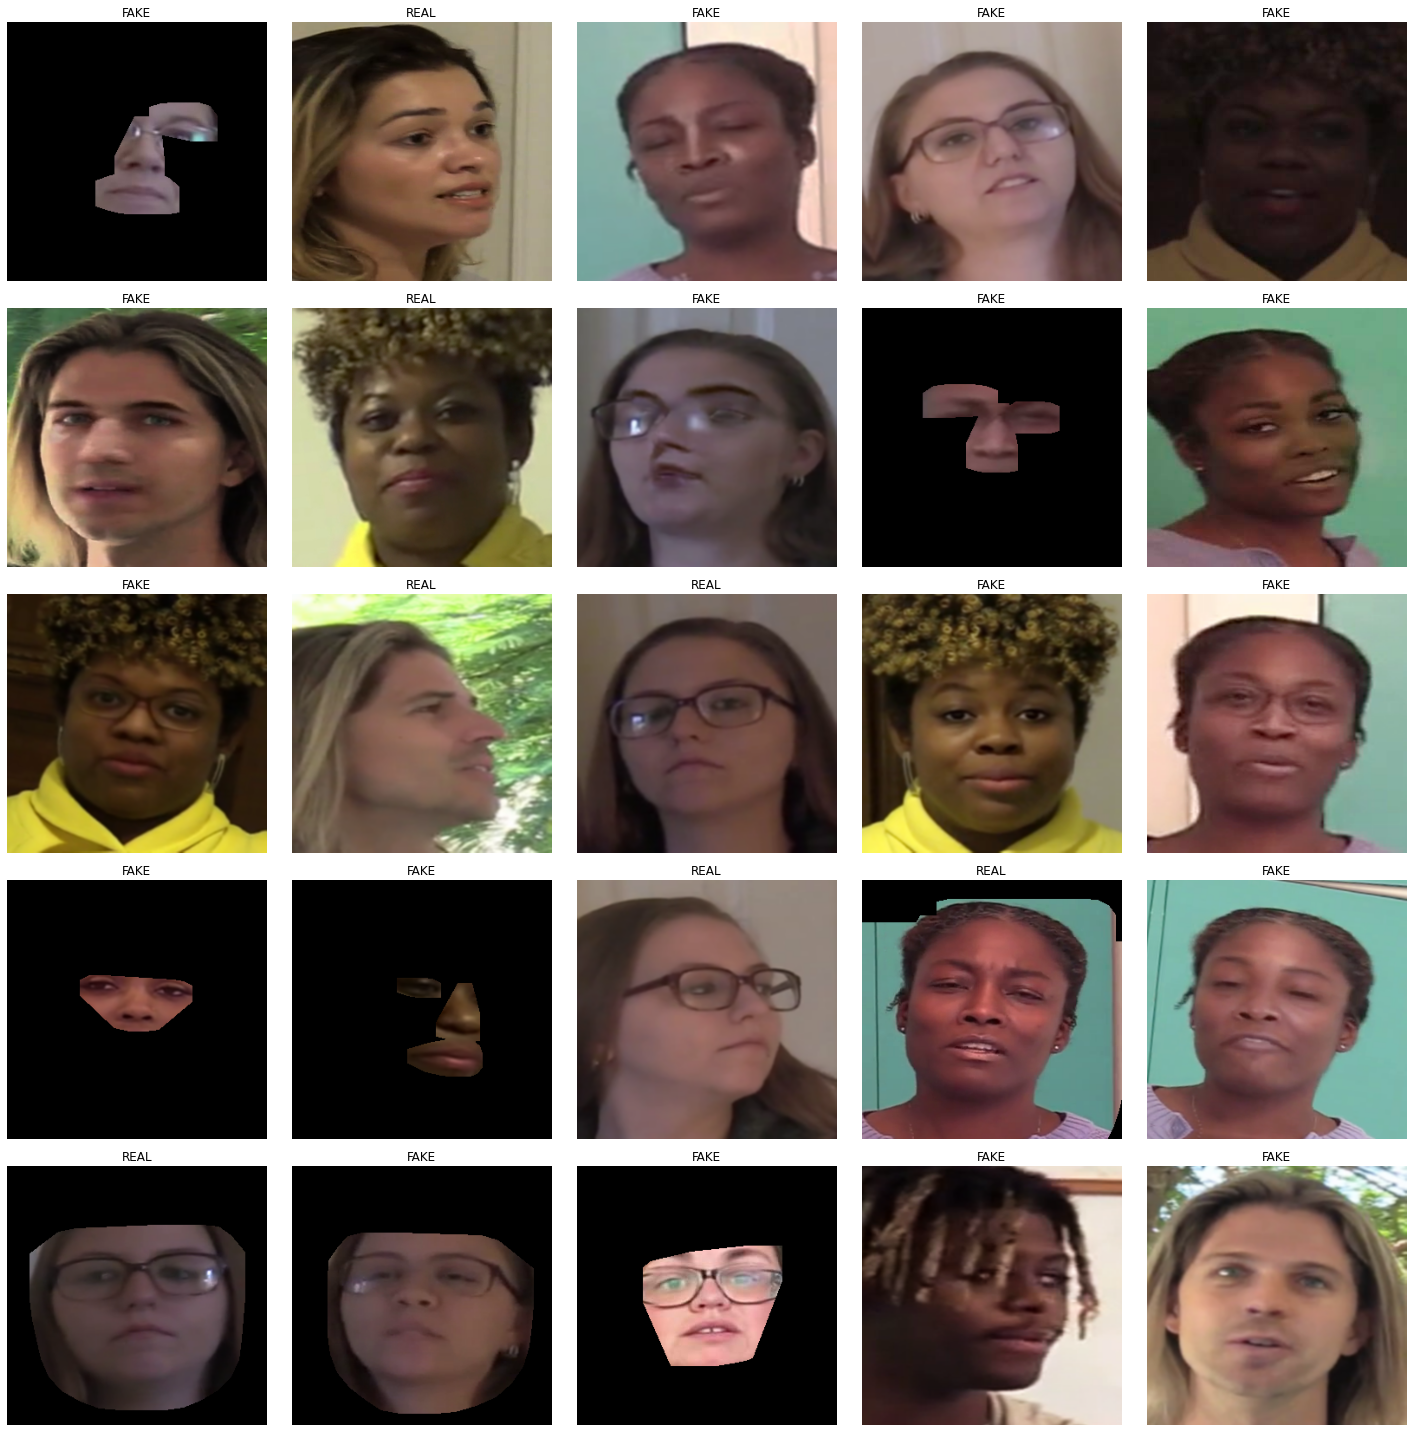

In [12]:
data = (ImageList.from_folder('/gdrive/My Drive/dfdc/frame folders3/train/')
        .split_by_valid_func(is_validation)
        .label_from_folder()
        .add_test_folder('/gdrive/My Drive/dfdc/frame folders3/test')
        .transform(transforms)
        .databunch(bs=50)).normalize(imagenet_stats) #b3 ~ 95 batch, b5 ~50

data.show_batch()

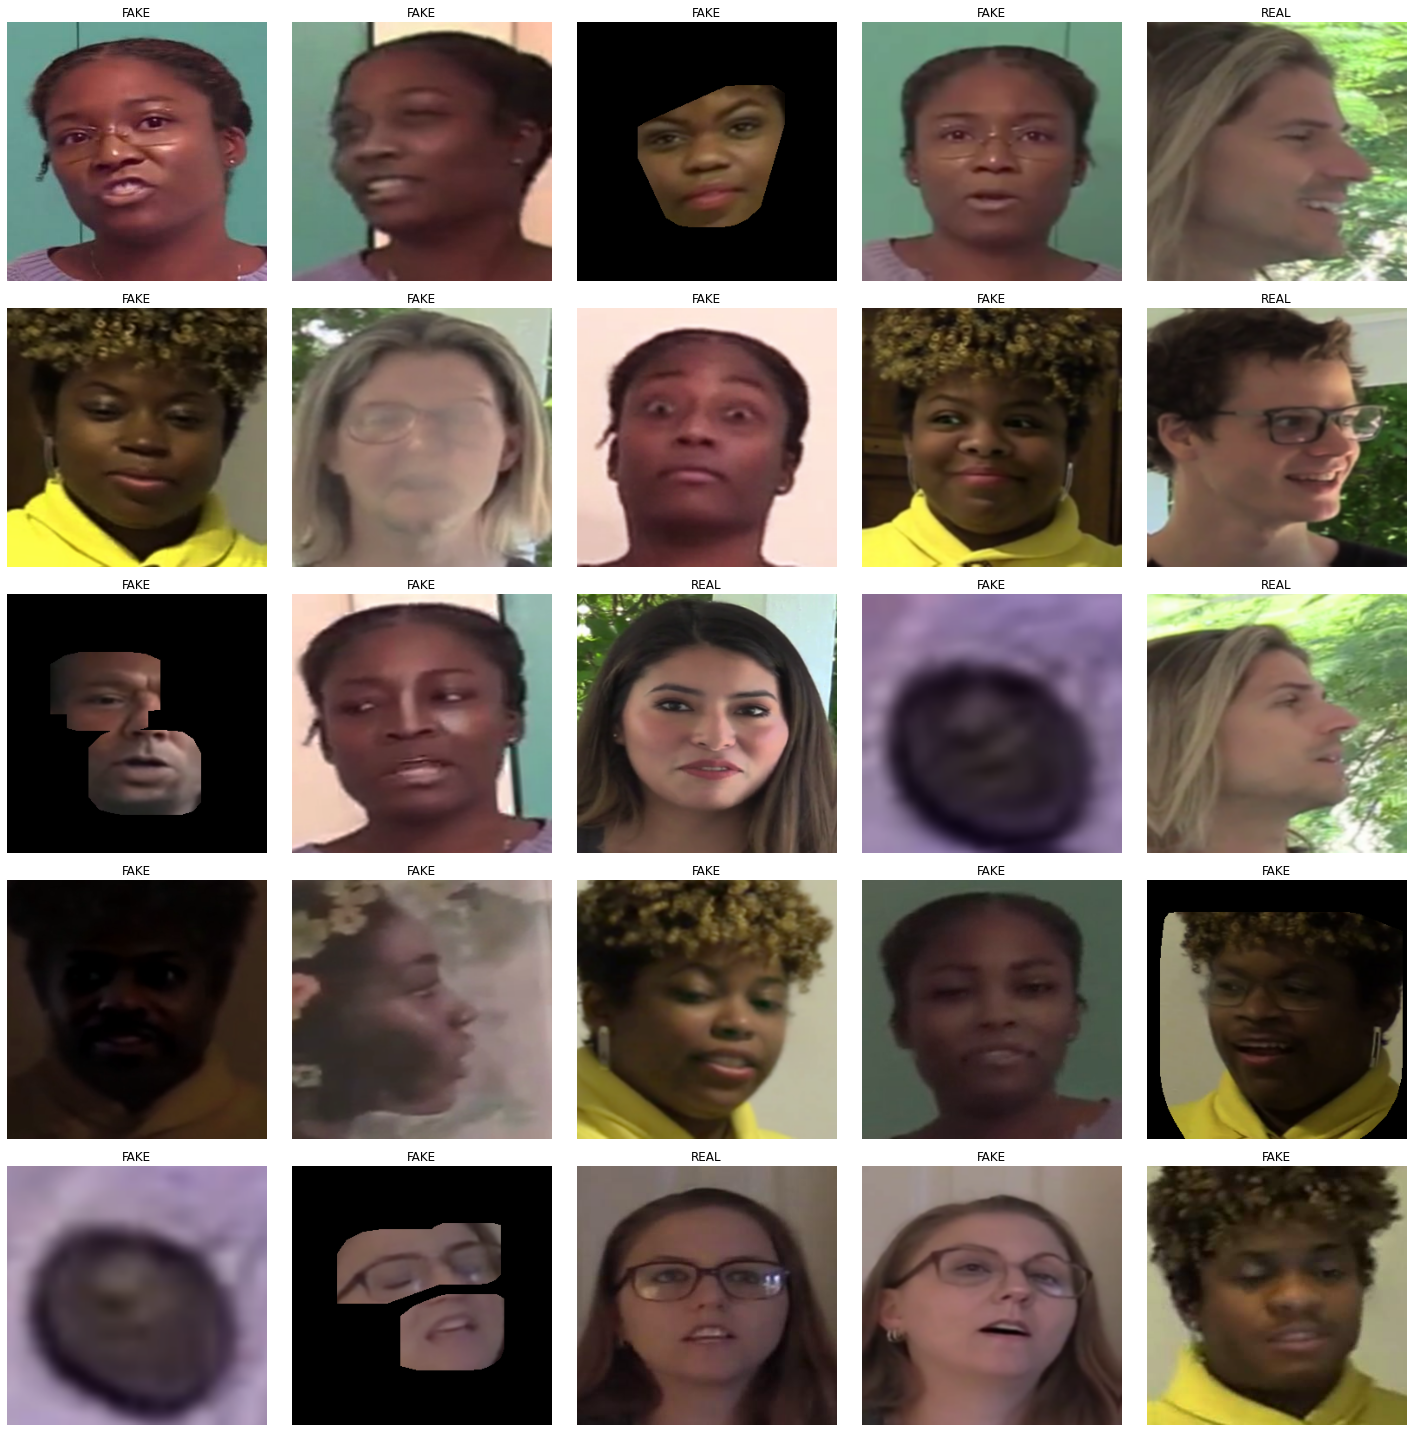

In [13]:
data.show_batch()

In [14]:
collections.Counter(data.train_ds.y) # training dataset labels counts

Counter({Category 0: 4416, Category 1: 1186})

In [15]:
collections.Counter(data.valid_ds.y) # validation set label counts

Counter({Category 0: 861, Category 1: 226})

In [16]:
!pip install efficientnet-pytorch geffnet

In [0]:
from fastai.callbacks import *
from fastai.callbacks.mem import PeakMemMetric
from fastai.vision import *
from fastai.metrics import *
from efficientnet_pytorch import EfficientNet
from functools import partial
from collections import OrderedDict
import torch.nn as nn
import geffnet

def get_learner():

    model = EfficientNet.from_pretrained("efficientnet-b5", num_classes=2) # use pretrained weights for base of network

    # replace last classification layer with some more classification layers
    model._fc = nn.Sequential(  
        nn.Linear(model._fc.in_features, model._fc.in_features // 2),
        nn.ReLU(),
        nn.Linear(model._fc.in_features // 2, 2)
    )

    #model._fc = nn.Linear(1280, data.c)# the last layer... # works for b0,b1
    #model._fc = nn.Linear(1536, data.c)# the last layer... B3
    #model._fc = nn.Linear(1792, data.c)# the last layer... B4
    #model._fc = nn.Linear(2048, data.c)# the last layer... B5
    #model._fc = nn.Linear(2304, data.c)# the last layer... B6
    #model._fc = nn.Linear(2560, data.c)# the last layer... B7
    #model._fc = nn.Linear(2816, data.c)# the last layer... B8

    stop_on_validation_loss_divergence = partial(EarlyStoppingCallback, monitor='valid_loss', mode='min', min_delta = 0, patience=5)

    learn = Learner(
        data, model, 
        callback_fns = [OverSamplingCallback, stop_on_validation_loss_divergence, PeakMemMetric],  # balance class weights, stop if validation loss diverges, record gpu memory usage
        metrics=[accuracy, error_rate] # list accuracy, record error rate (same as 1-accuracy ...)
        ).to_fp16() # convert to half precision for faster execution
    #learn.model[-1] = head
    return learn        

In [18]:
learner = get_learner()

Loaded pretrained weights for efficientnet-b5


In [19]:
learner.model.cuda() # put on gpu for faster execution

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [20]:
learner = learner.split([learner.model._conv_stem,learner.model._blocks,learner.model._conv_head]) # split into layers so that freezing/unfreezing works

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03
Min loss divided by 10: 9.12E-04


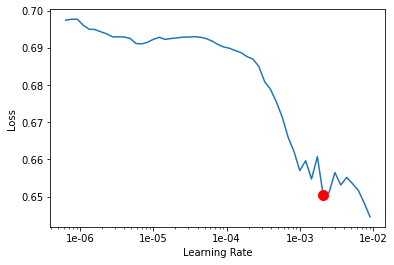

In [21]:
learner.unfreeze()
learner.lr_find() # find learning rate
learner.recorder.plot(suggestion=True) # plot learning rate vs loss landscape

In [0]:
# run for many epochs....
# classification interpretation
# interpretation.plot top losses

In [23]:
!nvidia-smi

Tue May 12 03:19:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    42W / 250W |   3321MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

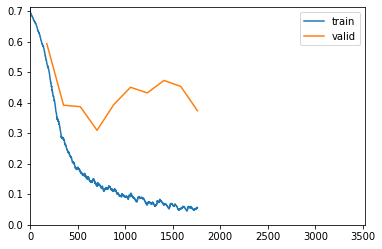

Better model found at epoch 0 with error_rate value: 0.32290711998939514.
Better model found at epoch 1 with error_rate value: 0.15363384783267975.
Better model found at epoch 2 with error_rate value: 0.1370745152235031.
Better model found at epoch 3 with error_rate value: 0.10947562754154205.
Better model found at epoch 4 with error_rate value: 0.10763570666313171.
Better model found at epoch 5 with error_rate value: 0.09751610457897186.
Better model found at epoch 6 with error_rate value: 0.0846366211771965.
Epoch 9: early stopping


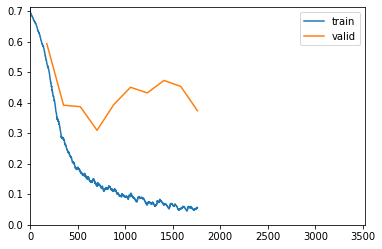

In [24]:
# use cyclic learning rate
# show graph while training. 
# train last layer w/ lr= 1e-3. by default if you only list one slice, all others get 1/10th the learning rate
# also save the model and when finished use the best one yet discovered, as measured by error rate

learner.fit_one_cycle(20, learner.lr_range(slice(1e-3)), callbacks=[ShowGraph(learner), SaveModelCallback(learner, monitor='error_rate', mode='min', name='best_efficientnet_b5_model')])

In [25]:
# make earlier layers untrainable, and finetune the last layers only
learner.freeze()
learner.fit_one_cycle(5, 5e-4)

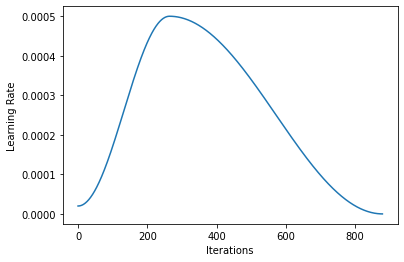

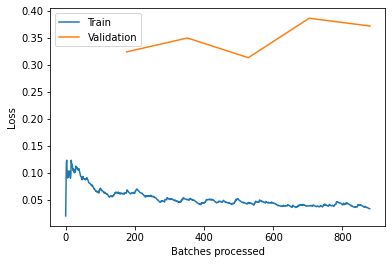

In [26]:
learner.recorder.plot_lr()
learner.recorder.plot_losses()


In [0]:
import time
def backup_and_interpret():
    learner.save(f'diagnostic_{time.time()}_early_stopping_final')
    learner.to_fp32() # convert back to full precision otherwise classificationinterpretation doesn't work properly
    preds,y,losses=learner.get_preds(with_loss=True)
    interpretation=ClassificationInterpretation(learner,preds,y,losses)
    print("worst loss")
    interpretation.plot_top_losses(64,figsize=(49,49))
    plt.show()
    print("best loss")
    interpretation.plot_top_losses(64,figsize=(49,49), largest=False)
    learner.to_fp16()
    plt.show()
backup_and_interpret()

In [29]:
probs, classes, losses = learner.get_preds(with_loss=True, ds_type=DatasetType.Valid)

# in validation set: 1087


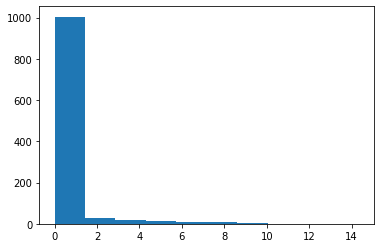

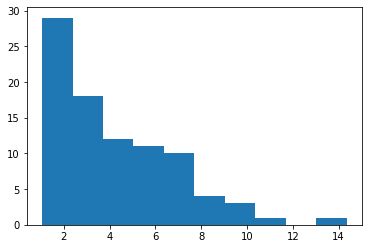

In [38]:
print(f"# in validation set: {len(losses)}")
prob_real = [prob[0] for prob in probs]
prob_fake = [prob[1] for prob in probs]
plt.hist(losses)
plt.show()
plt.hist([loss for loss in losses if loss > 1])
plt.show()

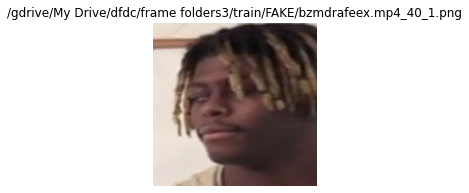

loss: 14.343750953674316
p(real): 5.896417860640213e-07 p(fake): 0.9999994039535522
actually: FAKE
filename: (Image (3, 300, 300), Category 0)


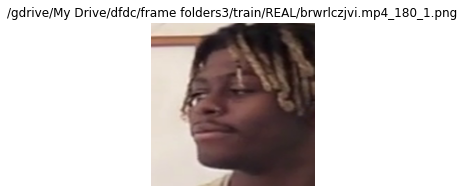

loss: 10.847675323486328
p(real): 0.9999805688858032 p(fake): 1.9449762476142496e-05
actually: REAL
filename: (Image (3, 300, 300), Category 1)


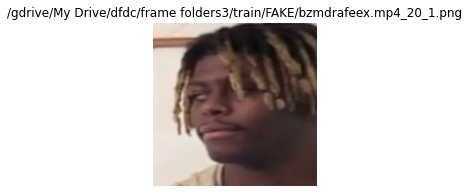

loss: 9.984420776367188
p(real): 4.611274562194012e-05 p(fake): 0.9999538660049438
actually: FAKE
filename: (Image (3, 300, 300), Category 0)


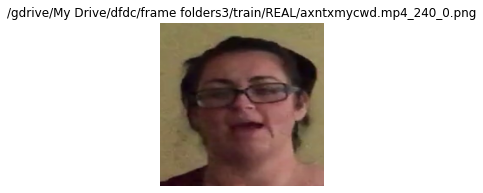

loss: 9.464920997619629
p(real): 0.999922513961792 p(fake): 7.752413512207568e-05
actually: REAL
filename: (Image (3, 300, 300), Category 1)


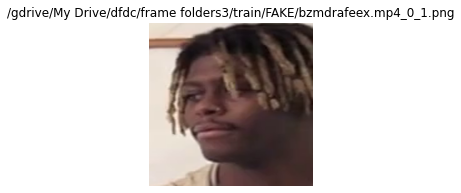

loss: 9.308684349060059
p(real): 9.063370089279488e-05 p(fake): 0.9999094009399414
actually: FAKE
filename: (Image (3, 300, 300), Category 0)


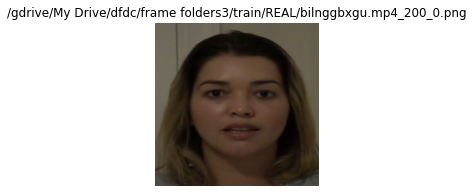

loss: 8.92982006072998
p(real): 0.9998675584793091 p(fake): 0.00013238185783848166
actually: REAL
filename: (Image (3, 300, 300), Category 1)


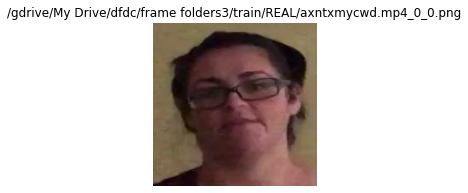

loss: 8.754063606262207
p(real): 0.9998421669006348 p(fake): 0.00015781863476149738
actually: REAL
filename: (Image (3, 300, 300), Category 1)


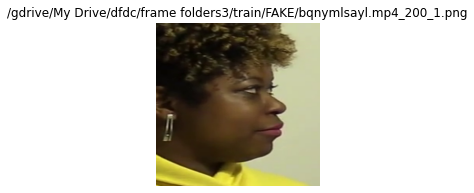

loss: 7.920285224914551
p(real): 0.00036329866270534694 p(fake): 0.9996366500854492
actually: FAKE
filename: (Image (3, 300, 300), Category 0)


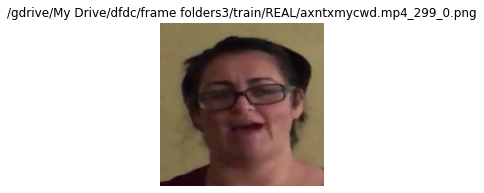

loss: 7.805095195770264
p(real): 0.9995923638343811 p(fake): 0.00040765260928310454
actually: REAL
filename: (Image (3, 300, 300), Category 1)


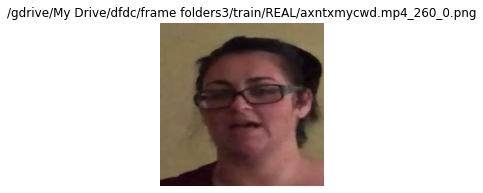

loss: 7.662579536437988
p(real): 0.9995299577713013 p(fake): 0.00047009321860969067
actually: REAL
filename: (Image (3, 300, 300), Category 1)


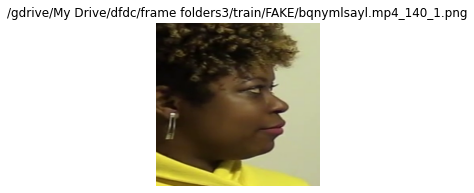

loss: 7.6567230224609375
p(real): 0.00047285447362810373 p(fake): 0.9995272159576416
actually: FAKE
filename: (Image (3, 300, 300), Category 0)


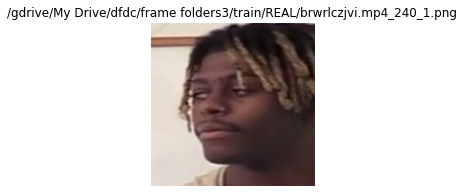

loss: 7.4556565284729
p(real): 0.9994218349456787 p(fake): 0.0005781620275229216
actually: REAL
filename: (Image (3, 300, 300), Category 1)


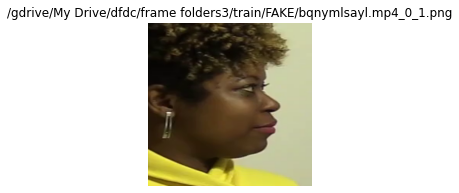

loss: 7.3736748695373535
p(real): 0.0006275578634813428 p(fake): 0.9993724226951599
actually: FAKE
filename: (Image (3, 300, 300), Category 0)


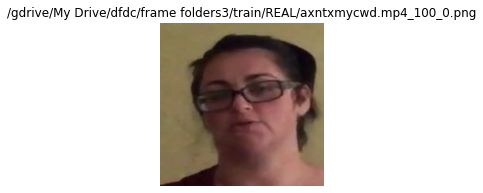

loss: 7.34244441986084
p(real): 0.9993525147438049 p(fake): 0.0006474658148363233
actually: REAL
filename: (Image (3, 300, 300), Category 1)


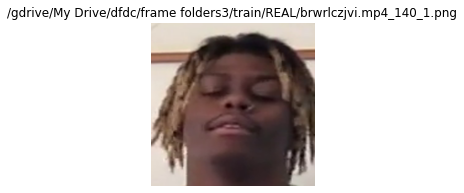

loss: 7.1589813232421875
p(real): 0.9992221593856812 p(fake): 0.0007778465515002608
actually: REAL
filename: (Image (3, 300, 300), Category 1)


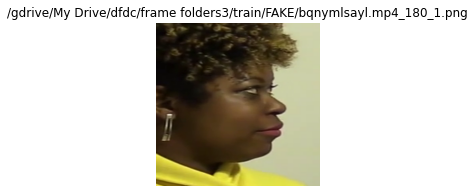

loss: 6.872130393981934
p(real): 0.0010362669127061963 p(fake): 0.9989637136459351
actually: FAKE
filename: (Image (3, 300, 300), Category 0)


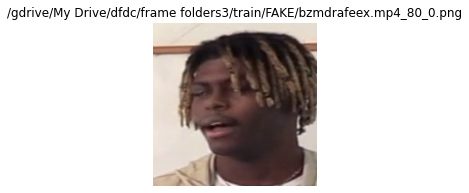

loss: 6.870179653167725
p(real): 0.0010382906766608357 p(fake): 0.9989616870880127
actually: FAKE
filename: (Image (3, 300, 300), Category 0)


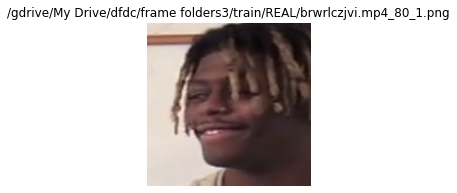

loss: 6.7004499435424805
p(real): 0.9987695813179016 p(fake): 0.0012303581461310387
actually: REAL
filename: (Image (3, 300, 300), Category 1)


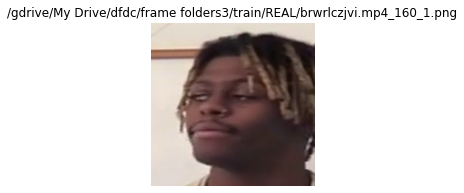

loss: 6.669239044189453
p(real): 0.9987305998802185 p(fake): 0.0012693643802776933
actually: REAL
filename: (Image (3, 300, 300), Category 1)


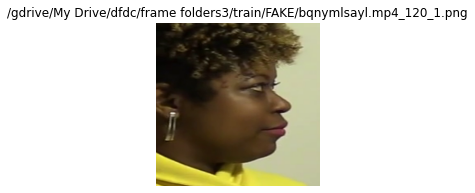

loss: 6.267523765563965
p(real): 0.0018969199154525995 p(fake): 0.9981030225753784
actually: FAKE
filename: (Image (3, 300, 300), Category 0)


In [39]:
for i in np.argsort(losses*-1, axis=0)[:20]: # top 20 worst losses
    show_image(data.valid_ds[i][0])
    plt.title(data.valid_ds.items[i])
    plt.show()
    print(f"loss: {losses[i]}")
    print(f"p(real): {probs[i][0]} p(fake): {probs[i][1]}")
    print(f"actually: {data.valid_ds.y[i]}")
    print(f"filename: {data.valid_ds[i]}")

Validation set confusion matrix:


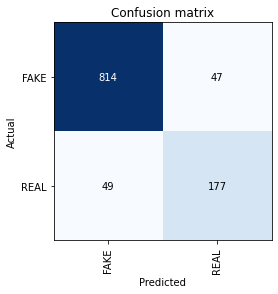

Normalized:


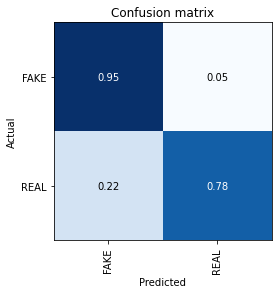

In [37]:
interp_valid = ClassificationInterpretation(learner, probs, classes, losses)
print("Validation set confusion matrix:")
interp_valid.plot_confusion_matrix()
plt.show()
print("Normalized:")
interp_valid.plot_confusion_matrix(normalize=True)

The following code is from an attempt to create a submission for the faceforensics++ benchmark, but it worked poorly so I didn't work on it much.

In [0]:
import torchvision.transforms
def prepare_benchmark_submission():
    learner.model.eval()
    predictions = {i: None for i in range(1000)}

    normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(300),
    torchvision.transforms.ToTensor(),
    normalize
    ])

    for image_num in range(1000):
        for image_num_face_full_image_path in glob.glob(f"/gdrive/My Drive/dfdc/faceforensics_face_extractions/{str(image_num).zfill(4)}_face*.png"):
            face_num = os.path.basename(image_num_face_full_image_path).split('face')[1][:-4]
            print(image_num, face_num)
            face_img = open_image(image_num_face_full_image_path)#.normalize(imagenet_stats)
            show_image(face_img)
            plt.show()
            learner.to_fp16()
            pred_class, pred_idx, outputs = learner.predict(face_img)
            print(outputs)
            probs = torch.nn.functional.softmax(np.log(outputs))
            print(f"probs: {probs}")
            if probs[1] > 0.001: #probs[0]:
                print(f"classed this (img {image_num} face #{face_num}) as fake:")
                #show_image(face_img)
                predictions[image_num] = 'FAKE'
                break
            #if probs[0] > probs[1]: print('REAL')
            else:
                print('REAL')
        if predictions[image_num] == None: predictions[image_num] = 'REAL'

    prediction_json_dict = {(str(idx).zfill(4) + '.png'): prediction.lower() for idx, prediction in predictions.items()} # convert e.g. 1:FAKE -> "0001.png": "fake"
    pprint.pprint(prediction_json_dict)
    with open('face_forensics_benchmark_submission.json', 'w') as fp:
        json.dump(prediction_json_dict, fp)

prepare_benchmark_submission()